<a href="https://colab.research.google.com/github/soheekim911/Standalone_DL/blob/master/assignment03_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir results

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt
import pdb

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified


## Model Architecture

In [0]:
class MLP(nn.Module):
    
    def __init__(self, in_dim, hid_dim, out_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim= in_dim
        self.hid_dim= hid_dim
        self.out_dim = out_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ====== Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer -1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Activation Function ======= #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act = nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
            
        # ====== Regularization Layer ====== #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()
            
    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
            
net = MLP(3072, 100, 10, 4, 'relu', 0.3, True, True)
            
        

## Train, Validate, Test and Experiment

In [0]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                             batch_size=args.train_batch_size,
                                             shuffle=True, num_workers=2)
    
    net.train()
    optimizer.zero_grad()
    
    correct=0
    total=0
    train_loss=0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
#         print(inputs.shape)
        inputs = inputs.view(-1,3072)
#         break
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
#         print(type(outputs))
#         pdb.set_trace()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() ##item??
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) ##size??
        correct += (predicted==labels).sum().item()
        
    train_loss = train_loss / len(trainloader)
    train_acc = 100* correct / total
    return net, train_loss, train_acc

In [0]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [0]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

## Experiment

In [0]:
def experiment(partition, args):
  
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} seconds'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

## Manage Experiment Result

**json, hashlib 연습**

In [0]:
# json 파일 다루기

import json

a = {'value': 34, 'value2': 48, 'seq':[5,3,1,8]}

filename = 'test1.json'
with open(filename, 'w') as f:
    json.dump(a,f)
    
with open(filename, 'r') as f2:
    result= json.load(f2)
    print(result)

{'value': 34, 'value2': 48, 'seq': [5, 3, 1, 8]}


In [0]:
# 해쉬 넣은 파일이름 만들기

import hashlib
setting = {'value':5, 'value2':2, 'seq':[1,2,3,4,5], 'exp_name':'exp1'} 

exp_name = setting['exp_name']
hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]

filename = '{}-{}.json'.format(exp_name, hash_key)
print(filename)

exp1-93ae14.json


In [0]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    
    return df

In [0]:
!ls

data  results  sample_data  test1.json


## Visualization 

In [0]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]
 
            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

In [0]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1, 2, 3]
list_var2 = [500, 300]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp1_n_layer_hid_dim', hid_dim=500, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=1, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=512, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 25.96/25.85, Loss(train/val) 2.74/2.10. Took 10.66 seconds
Epoch 1, Acc(train/val): 32.52/32.85, Loss(train/val) 1.90/1.90. Took 12.12 seconds
Epoch 2, Acc(train/val): 35.98/35.28, Loss(train/val) 1.81/1.85. Took 12.14 seconds
Epoch 3, Acc(train/val): 37.86/34.60, Loss(train/val) 1.77/1.86. Took 12.13 seconds
Epoch 4, Acc(train/val): 38.92/37.60, Loss(train/val) 1.74/1.79. Took 12.28 seconds
Epoch 5, Acc(train/val): 39.07/35.93, Loss(train/val) 1.73/1.81. Took 12.34 seconds
Epoch 6, Acc(train/val): 39.91/35.80, Loss(train/val) 1.72/1.83. Took 12.07 seconds
Epoch 7, Acc(train/val): 40.20/36.62, Loss(train/val) 1.70/1.80. Took 12.12 seconds
Epoch 8, Acc(train/val): 39.25/35.58, Loss(train/val) 1.71/1.82. Took 12.31 seconds
Epoch

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


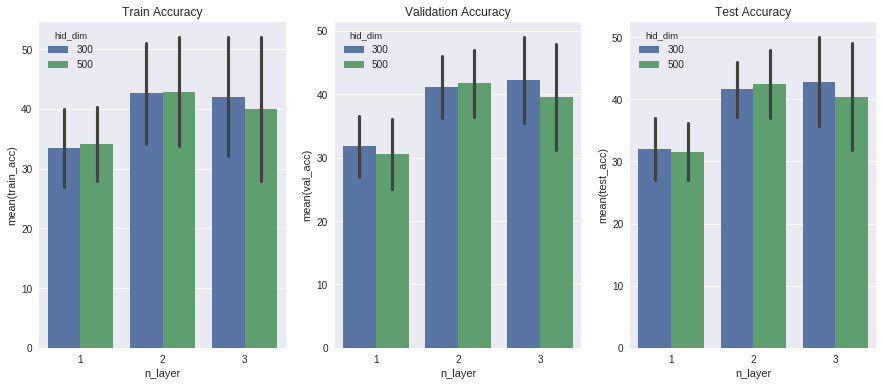

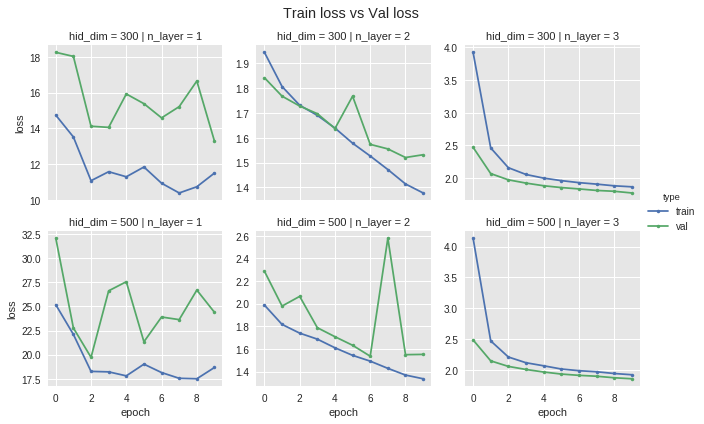

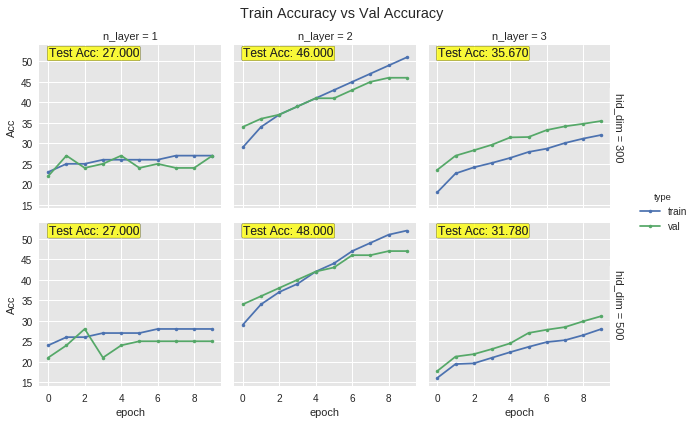

In [0]:
var1 = 'n_layer'
var2 = 'hid_dim'
df = load_exp_result('exp1')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.

In [0]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.3
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0005
args.epoch = 10

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [2, 3, 4]
list_var2 = [200, 300]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0.3, epoch=10, exp_name='exp1_n_layer_hid_dim', hid_dim=200, in_dim=3072, l2=1e-05, lr=0.0005, n_layer=2, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=512, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 12.63/20.23, Loss(train/val) 4.90/4.52. Took 11.75 seconds
Epoch 1, Acc(train/val): 19.35/21.31, Loss(train/val) 4.36/4.03. Took 12.56 seconds
Epoch 2, Acc(train/val): 20.70/23.23, Loss(train/val) 3.89/3.59. Took 12.56 seconds
Epoch 3, Acc(train/val): 22.20/24.17, Loss(train/val) 3.49/3.18. Took 12.62 seconds
Epoch 4, Acc(train/val): 22.89/25.87, Loss(train/val) 3.13/2.84. Took 12.93 seconds
Epoch 5, Acc(train/val): 24.01/27.20, Loss(train/val) 2.85/2.58. Took 12.62 seconds
Epoch 6, Acc(train/val): 25.20/28.62, Loss(train/val) 2.62/2.36. Took 12.75 seconds
Epoch 7, Acc(train/val): 25.78/30.27, Loss(train/val) 2.44/2.20. Took 12.61 seconds
Epoch 8, Acc(train/val): 26.83/31.20, Loss(train/val) 2.31/2.07. Took 13.03 seconds
Epoch

In [0]:
whos

Variable              Type                          Data/Info
-------------------------------------------------------------
F                     module                        <module 'torch.nn.functio<...>/torch/nn/functional.py'>
MLP                   type                          <class '__main__.MLP'>
a                     dict                          n=3
argparse              module                        <module 'argparse' from '<...>b/python3.6/argparse.py'>
args                  Namespace                     Namespace(act='relu', dro<...>bn=True, use_xavier=True)
deepcopy              function                      <function deepcopy at 0x7f60059b5b70>
df                    DataFrame                          act  dropout        <...>18532943726, 3.84982...  
exp_name              str                           exp1
experiment            function                      <function experiment at 0x7f5f9d8d8f28>
f                     TextIOWrapper                 <_io.TextIOWrapper nam

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


IndexError: ignored

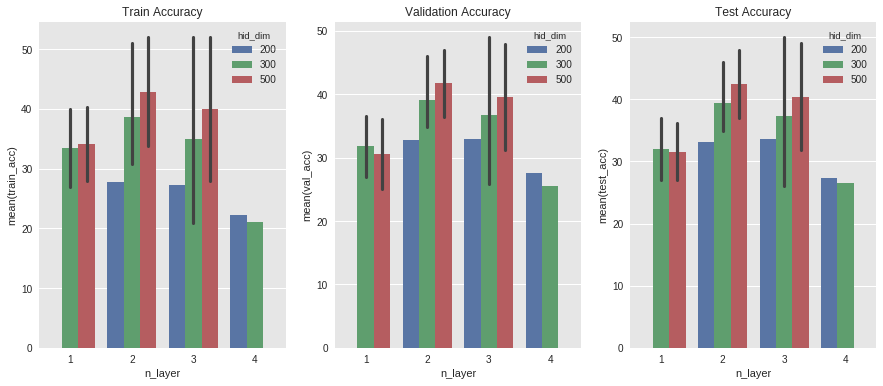

In [0]:
var1 = 'n_layer'
var2 = 'hid_dim'
df = load_exp_result('exp1') # 이름 바꿔야 하는데...ㅠ

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=True) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.

In [0]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp3_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.4
args.use_bn = True
args.l2 = 0.0001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 10

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1,2,3]
list_var2 = [200,300,400,500]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0.4, epoch=10, exp_name='exp3_n_layer_hid_dim', hid_dim=200, in_dim=3072, l2=0.0001, lr=0.0001, n_layer=1, optim='Adam', out_dim=10, test_batch_size=1024, train_batch_size=512, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 2.68/6.05, Loss(train/val) 5.10/4.94. Took 10.53 seconds
Epoch 1, Acc(train/val): 6.66/9.48, Loss(train/val) 4.77/4.63. Took 11.87 seconds
Epoch 2, Acc(train/val): 11.15/10.83, Loss(train/val) 4.54/4.52. Took 11.90 seconds
Epoch 3, Acc(train/val): 13.82/14.57, Loss(train/val) 4.31/4.32. Took 11.87 seconds
Epoch 4, Acc(train/val): 18.13/17.94, Loss(train/val) 4.08/3.91. Took 11.86 seconds
Epoch 5, Acc(train/val): 19.58/21.87, Loss(train/val) 3.75/3.60. Took 11.91 seconds
Epoch 6, Acc(train/val): 24.71/25.35, Loss(train/val) 3.49/3.37. Took 11.92 seconds
Epoch 7, Acc(train/val): 25.78/23.77, Loss(train/val) 3.25/3.19. Took 11.89 seconds
Epoch 8, Acc(train/val): 26.93/26.18, Loss(train/val) 3.06/3.10. Took 11.98 seconds
Epoch 9, Ac

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


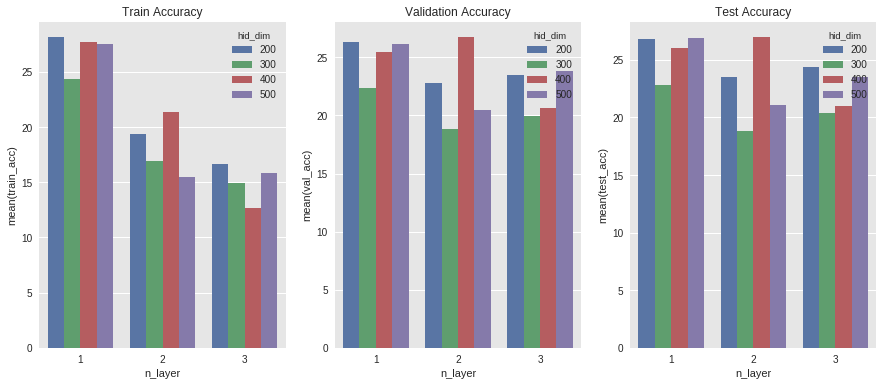

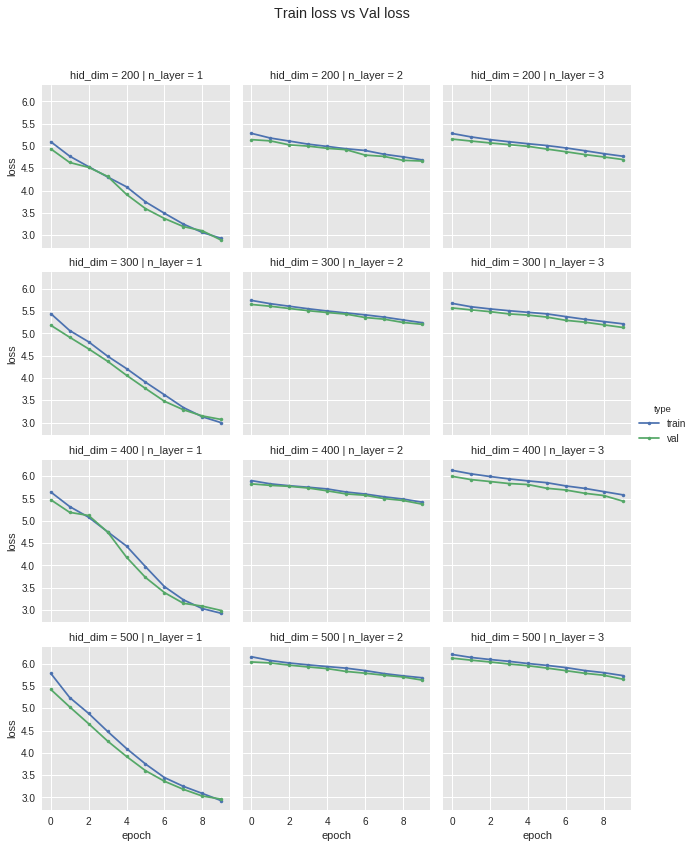

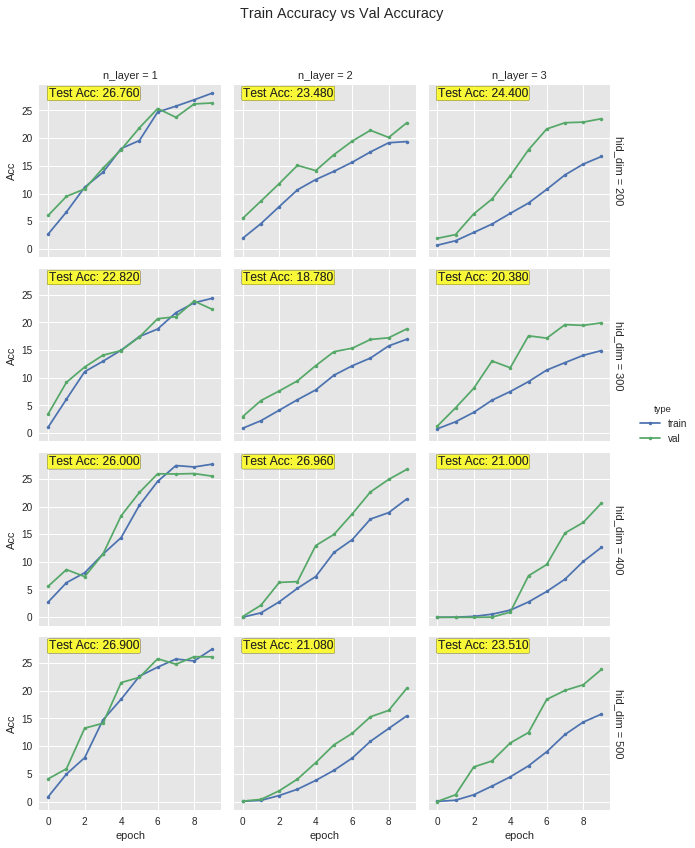

In [0]:
var1 = 'n_layer'
var2 = 'hid_dim'
df = load_exp_result('exp3') 

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=True) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.

In [0]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp4_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0003
args.epoch = 10

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1,2]
list_var2 = [200,500]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp4_n_layer_hid_dim', hid_dim=200, in_dim=3072, l2=1e-05, lr=0.0003, n_layer=1, optim='Adam', out_dim=10, test_batch_size=1024, train_batch_size=512, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 6.24/13.20, Loss(train/val) 4.96/4.79. Took 11.32 seconds
Epoch 1, Acc(train/val): 15.71/17.56, Loss(train/val) 4.41/4.44. Took 12.60 seconds
Epoch 2, Acc(train/val): 21.91/22.65, Loss(train/val) 4.07/3.85. Took 12.77 seconds
Epoch 3, Acc(train/val): 22.14/21.31, Loss(train/val) 3.56/3.33. Took 12.78 seconds
Epoch 4, Acc(train/val): 26.11/24.76, Loss(train/val) 2.90/2.82. Took 12.65 seconds
Epoch 5, Acc(train/val): 26.88/26.01, Loss(train/val) 2.70/2.76. Took 12.80 seconds
Epoch 6, Acc(train/val): 28.65/26.09, Loss(train/val) 2.55/2.63. Took 12.87 seconds
Epoch 7, Acc(train/val): 28.11/24.42, Loss(train/val) 2.64/2.88. Took 12.72 seconds
Epoch 8, Acc(train/val): 27.56/24.59, Loss(train/val) 2.57/2.82. Took 12.91 seconds
Epoch 9, 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


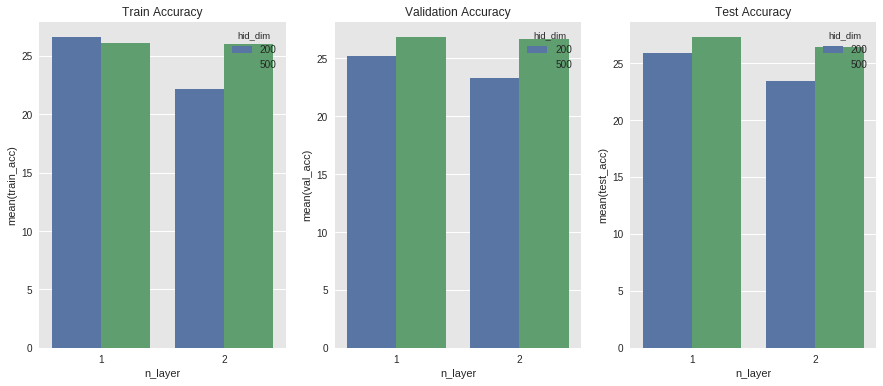

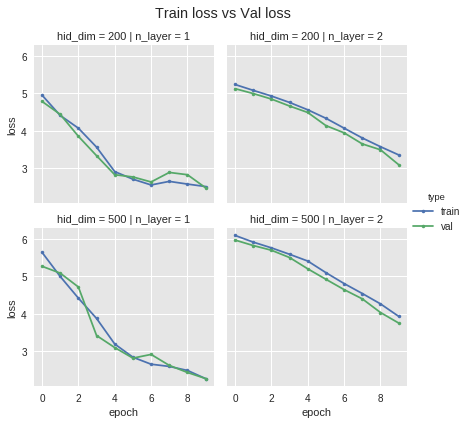

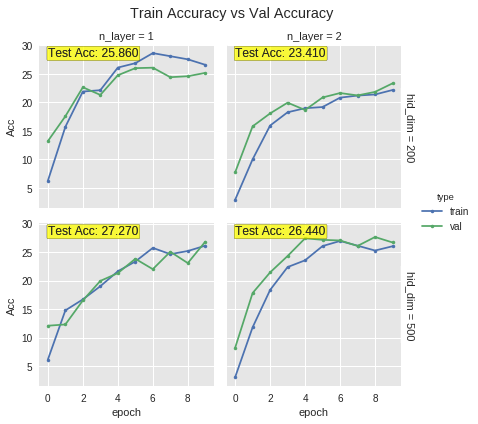

In [0]:
var1 = 'n_layer'
var2 = 'hid_dim'
df = load_exp_result('exp4') 

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=True) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.

In [0]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp5_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0003
args.epoch = 10

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1,2]
list_var2 = [500]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp5_n_layer_hid_dim', hid_dim=500, in_dim=3072, l2=1e-05, lr=0.0003, n_layer=1, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=512, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 21.17/29.48, Loss(train/val) 4.20/3.12. Took 11.08 seconds
Epoch 1, Acc(train/val): 31.99/31.61, Loss(train/val) 2.82/2.49. Took 12.12 seconds
Epoch 2, Acc(train/val): 35.17/34.81, Loss(train/val) 2.33/2.21. Took 12.85 seconds
Epoch 3, Acc(train/val): 36.05/35.16, Loss(train/val) 2.11/2.11. Took 12.37 seconds
Epoch 4, Acc(train/val): 36.34/35.61, Loss(train/val) 2.01/2.03. Took 12.33 seconds
Epoch 5, Acc(train/val): 38.01/35.25, Loss(train/val) 1.94/1.99. Took 12.31 seconds
Epoch 6, Acc(train/val): 38.38/36.25, Loss(train/val) 1.89/1.94. Took 12.39 seconds
Epoch 7, Acc(train/val): 38.65/34.96, Loss(train/val) 1.85/1.92. Took 12.33 seconds
Epoch 8, Acc(train/val): 38.72/36.02, Loss(train/val) 1.83/1.87. Took 12.23 seconds
Epoch

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


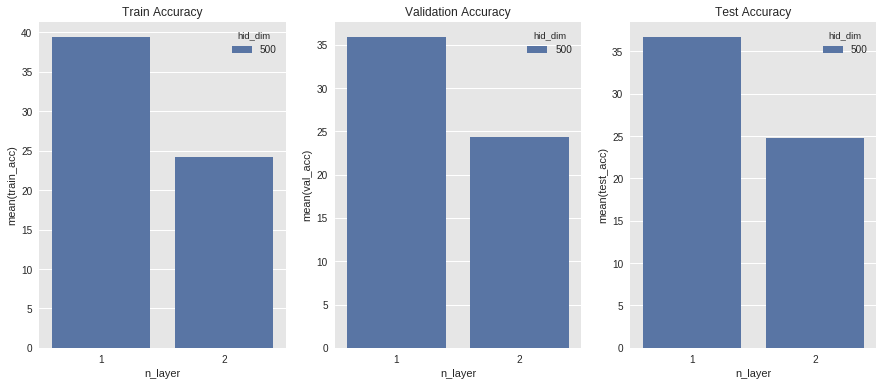

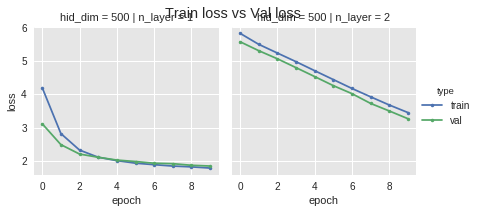

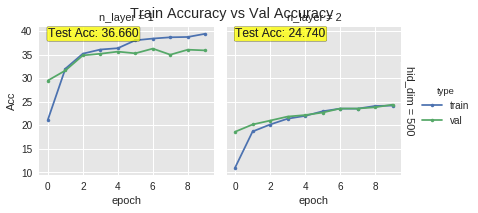

In [0]:
var1 = 'n_layer'
var2 = 'hid_dim'
df = load_exp_result('exp5') 

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=True) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.

In [0]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp6_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0003
args.epoch = 10

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1]
list_var2 = [100,300,500]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp6_n_layer_hid_dim', hid_dim=100, in_dim=3072, l2=1e-05, lr=0.0003, n_layer=1, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=512, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 23.58/31.86, Loss(train/val) 3.10/2.45. Took 11.87 seconds
Epoch 1, Acc(train/val): 34.86/34.78, Loss(train/val) 2.27/2.11. Took 12.57 seconds
Epoch 2, Acc(train/val): 36.49/35.06, Loss(train/val) 2.03/1.99. Took 12.73 seconds
Epoch 3, Acc(train/val): 37.45/36.54, Loss(train/val) 1.92/1.92. Took 12.07 seconds
Epoch 4, Acc(train/val): 38.23/36.83, Loss(train/val) 1.86/1.91. Took 12.47 seconds
Epoch 5, Acc(train/val): 38.67/36.43, Loss(train/val) 1.84/1.90. Took 12.23 seconds
Epoch 6, Acc(train/val): 38.63/35.26, Loss(train/val) 1.82/1.89. Took 12.81 seconds
Epoch 7, Acc(train/val): 39.11/36.38, Loss(train/val) 1.80/1.87. Took 12.10 seconds
Epoch 8, Acc(train/val): 40.06/37.11, Loss(train/val) 1.76/1.81. Took 12.48 seconds
Epoch

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


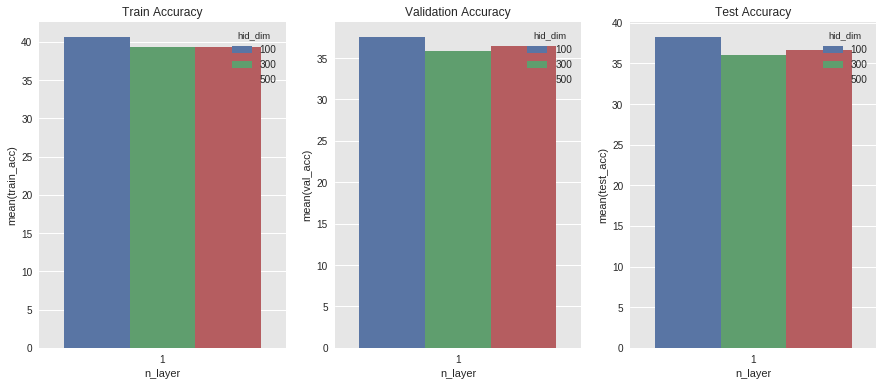

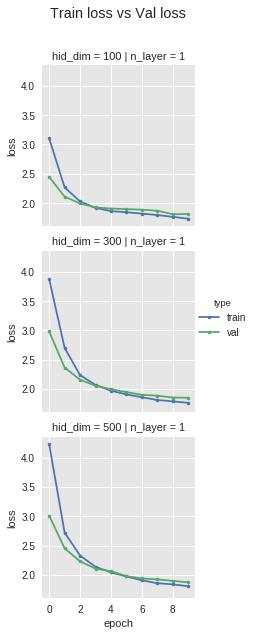

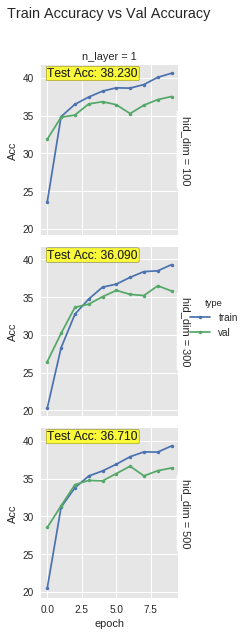

In [0]:
var1 = 'n_layer'
var2 = 'hid_dim'
df = load_exp_result('exp6') 

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=True) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.

In [0]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp7_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = False
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'SGD' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 10

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1,3]
list_var2 = [100,500]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp7_n_layer_hid_dim', hid_dim=100, in_dim=3072, l2=1e-05, lr=0.0001, n_layer=1, optim='SGD', out_dim=10, test_batch_size=1024, train_batch_size=512, use_bn=False, use_xavier=True)
Epoch 0, Acc(train/val): 3.71/5.49, Loss(train/val) 4.44/4.25. Took 9.60 seconds
Epoch 1, Acc(train/val): 5.82/7.28, Loss(train/val) 4.17/3.97. Took 9.98 seconds
Epoch 2, Acc(train/val): 9.79/16.74, Loss(train/val) 3.88/3.63. Took 9.99 seconds
Epoch 3, Acc(train/val): 17.06/20.61, Loss(train/val) 3.54/3.28. Took 9.97 seconds
Epoch 4, Acc(train/val): 21.20/24.37, Loss(train/val) 3.21/3.00. Took 9.91 seconds
Epoch 5, Acc(train/val): 24.55/25.66, Loss(train/val) 2.96/2.79. Took 9.95 seconds
Epoch 6, Acc(train/val): 25.55/26.39, Loss(train/val) 2.75/2.61. Took 9.93 seconds
Epoch 7, Acc(train/val): 26.65/28.01, Loss(train/val) 2.59/2.48. Took 9.93 seconds
Epoch 8, Acc(train/val): 28.09/28.84, Loss(train/val) 2.47/2.38. Took 9.95 seconds
Epoch 9, Acc(train/val

IndexError: ignored

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


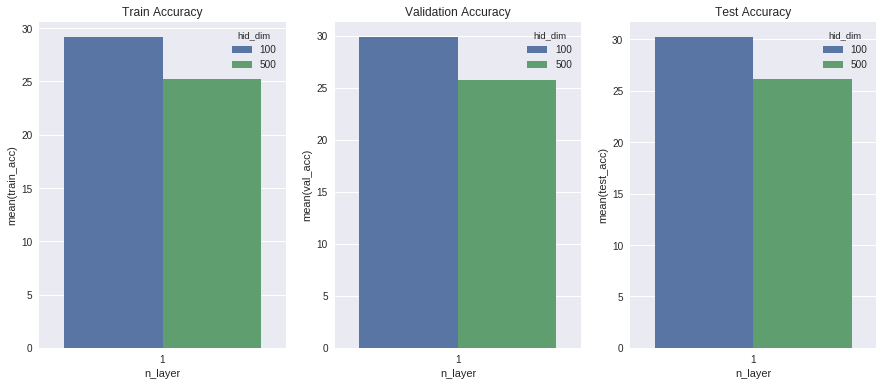

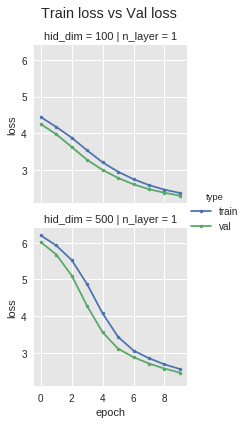

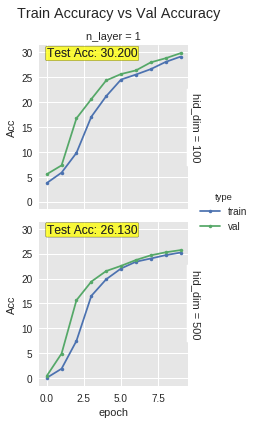

In [0]:
var1 = 'n_layer'
var2 = 'hid_dim'
df = load_exp_result('exp7') 

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=True) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.